<a href="https://colab.research.google.com/github/rodrigosimoncalaca/projectDataScience/blob/master/TrabalhoTitanicCluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analisando Dados do Titanic através de Cluster**

In [0]:
#importando as bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings("ignore")

## Obtendo Dados

Dados retirados do site https://www.kaggle.com/c/titanic/data)

In [0]:
titanic_dataset = pd.read_csv("/content/titanic.csv")

## Primeiras Análises

Esta etapa tem por objetivo criar uma consciência situacional inicial e permitir um entendimento de como os dados estão estruturados.

In [0]:
# Executar para mostrar as 5 primeiras linhas, e entendermos a estrutura para montar um dicionário das variáveis
titanic_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



## Dicionário de Dados

   
* PassengerId: Número de identificação do passageiro
* Survived: Informa se o passageiro sobreviveu ao desastre
    - 0 = Não
    - 1 = Sim
* Pclass: Classe do bilhete
    - 1 = 1ª Classe
    - 2 = 2ª Classe
    - 3 = 3ª Classe
* Name: Nome do passageiro
* Sex: Sexo do passageiro
* Age: Idade do passageiro
* SibSp: Quantidade de cônjuges e irmãos a bordo
* Parch: Quantidade de pais e filhos a bordo
* Ticket: Número da passagem
* Fare: Preço da Passagem
* Cabin: Número da cabine do passageiro
* Embarked: Porto no qual o passageiro embarcou
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton



### **Q1. Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

Vamos prosseguir e identificar a quantidade de entradas que nosso conjunto de dados possui e ver os tipos de cada coluna.


In [0]:
# identificar o volume de dados do DataFrame
print("Entradas:\t {}".format(titanic_dataset.shape[0]))
print("Variáveis:\t {}\n".format(titanic_dataset.shape[1]))

# verificar os tipos das variáveis
display(titanic_dataset.dtypes)

Entradas:	 891
Variáveis:	 12



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### **Q2. Qual a porcentagem de valores ausentes no *dataset*?**

A qualidade de um *dataset* está diretamente relacionada à quantidade de valores ausentes. É importante entender logo no início se esses valores nulos são significativos comparados ao total de entradas.


In [0]:
# ordenar em ordem decrescente as variáveis pela porcentagem de valores ausentes
(titanic_dataset.isnull().sum() / titanic_dataset.shape[0]).sort_values(ascending=False)*100

Cabin          77.104377
Age            19.865320
Embarked        0.224467
Fare            0.000000
Ticket          0.000000
Parch           0.000000
SibSp           0.000000
Sex             0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
PassengerId     0.000000
dtype: float64

### **Q3. Qual o tipo de distribuição das variáveis?** 

Para identificar a distribuição das variáveis, irei plotar o histograma, que tem como objetivo mostrar a distribuição de frequências de dados obtidos por medições, para identificarmos a frequência com que algo acontece.

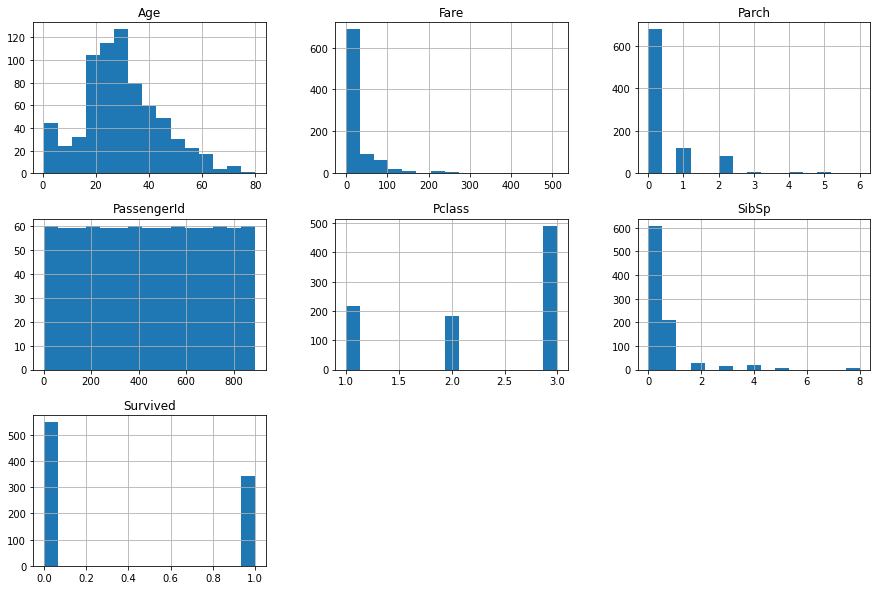

In [0]:
# plotar o histograma das variáveis numéricas
titanic_dataset.hist(bins=15, figsize=(15,10));

# **Pré-Processamento (Cluster)**

1. Crie um novo quadro de dados com colunas que determinarão os clusters
2. Codifique Sex colum para 0 e 1
3. Use o PCA para redução de dimensionalidade, para que possamos plotar pontos de dados facilmente

Como você pode ver, há uma coluna chamada Age (idade) que não está na mesma escala que o restante de nossos dados, mas como estamos usando o PCA, tudo estará na mesma escala.

## Criando novo quadro de dados

In [0]:
# Vamos excluir as colunas que não iremos usar
titanic_dataset_2 = titanic_dataset
titanic_dataset_2 = titanic_dataset_2.drop('Ticket', axis=1)
titanic_dataset_2 = titanic_dataset_2.drop('Cabin', axis=1)
titanic_dataset_2 = titanic_dataset_2.drop('Name', axis=1)
titanic_dataset_2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [0]:
# fillna() - é usado para atualizar valores ausentes com a média, moda ou mediana da coluna. 
titanic_dataset_2.fillna(0, inplace=True)

In [0]:
#Podemos observar que não existe mais valores ausentes
titanic_dataset_2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## Codificando a coluna Sexo usando LabelEncoder


In [0]:
#Biblioteca usada basicamente para converter os valores categórios em valores numéricos.
from sklearn.preprocessing import LabelEncoder

In [0]:
# O indexador iloc, seleciona por números inteiros das linhas, arrays ou por slice
# Parâmetro :,3 significa que quero transformar todas as linhas da coluna com indice 3, lembrando que a contagem começa no 0
encoder = LabelEncoder()
encoded_sex = encoder.fit_transform(titanic_dataset_2.iloc[:, 3])

In [0]:
#substituo a coluna Sex pelos novos valores que agora serão numéricos
titanic_dataset_2['Sex'] = encoded_sex

In [0]:
titanic_dataset_2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,S
1,2,1,1,0,38.0,1,0,71.2833,C
2,3,1,3,0,26.0,0,0,7.9250,S
3,4,1,1,0,35.0,1,0,53.1000,S
4,5,0,3,1,35.0,0,0,8.0500,S


In [0]:
# Estou gerando uma nova váriavel com todas as linhas a partir do indice 1 até a última coluna
features = titanic_dataset_2.iloc[:, 1:-1].values

In [0]:
print(features)

[[ 0.  3.  1. 22.  1.  0.]
 [ 1.  1.  0. 38.  1.  0.]
 [ 1.  3.  0. 26.  0.  0.]
 ...
 [ 0.  3.  0.  0.  1.  2.]
 [ 1.  1.  1. 26.  0.  0.]
 [ 0.  3.  1. 32.  0.  0.]]


## Clustering

### Método Cotovelo

In [0]:
#Váriavel alocada para considerar apenas a coluna receita anual e pontuação de gastos
X= titanic_dataset_2.iloc[:, [3,4]].values

In [0]:
from sklearn.cluster import KMeans
wcss=[]

In [0]:
#fórmula usada para segregar os pontos de dados em clusters
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

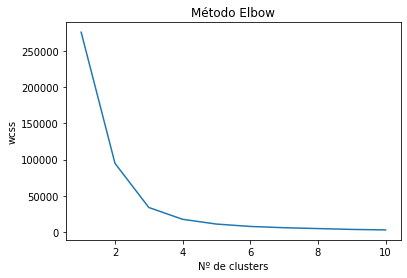

In [0]:
plt.plot(range(1,11), wcss)
plt.title('Método Elbow')
plt.xlabel('Nº de clusters')
plt.ylabel('wcss')
plt.show()

*Se diminuir o zoom nessa curva, podemos visualizar o último cotovelo em k = 3. Não importa o intervalo que selecionamos ex- (1,21), também veremos o mesmo comportamento, mas se escolhermos um intervalo mais alto, será pouco difícil visualizar o COTOVELO, é por isso que geralmente usamos o intervalo (1,11).*

**Concluimos então que k = 3**

In [0]:
#Model Build
kmeansmodel = KMeans(n_clusters= 3, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)

*Para aprendizado não supervisionado, usamos "fit_predict ()", e para aprendizado supervisionado usamos "fit_tranform ()". A variável y_kmeans é o modelo final. Agora, como e onde vamos implantar esse modelo na produção depende de qual ferramenta estamos usando. Neste caso de uso é muito comum e usado no setor de BFS (cartão de crédito) e no varejo para segmentação de clientes.*

Primeiro vamos usar a versão SKlearn do KMeans

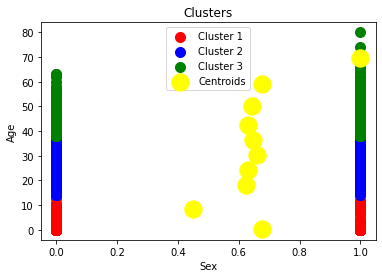

In [0]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.legend()
plt.show()

